<img src="https://i1.sndcdn.com/avatars-000274765548-vj7h0w-t500x500.jpg" style='float:right; width:200px; margin: 0 20px;'>

<img src="https://cdn2.iconfinder.com/data/icons/popular-social-media-flat/48/Popular_Social_Media-11-512.png" style='float:right; width:200px; margin: 0 20px;'>


# Twitter V CMV topological differences --> Twitter
---

> Create feature set for CMV and Twitter 

> Do comperative analysis of features

In [1]:
# env 
import sys
sys.path.append('/Users/shaimeital/code/thesis/conversant')
sys.path.append('/Users/shaimeital/code/thesis/cmv-stance-classification')


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import glob
import os

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [2]:
from conversant.conversation.examples.controversial_feature_extraction import *
from conversant.conversation\
    .conversation_utils import conversation_to_dataframe
from stance_classification.twitter_conversation_parser import TwitterConversationReader

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Load Raw Data

In [4]:
twitter_conversations_path = r"C:\Users\ronp\Documents\stance-classification\rumors_dataset\PHEME_veracity\full-conversations"
# twitter_conversations_path = "/Users/shaimeital/code/thesis/cmv-stance-classification/data/Twitter Conversation/rumers/full-conversations"
twitter_conversation_ids = [file for file in os.listdir(twitter_conversations_path)]

In [5]:
# one example
conv_id = "498235547685756928"
conversation_path = os.path.join(twitter_conversations_path, conv_id, "tweets.jsonl")
sample = pd.read_json(conversation_path,
                     lines= True,
                     dtype={'in_reply_to_status_id_str':str, 'conversation_id_str': str, 'full_text':str, 'id_str':str})
sample

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,created_at,id_str,full_text,display_text_range,entities,extended_entities,source,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,user_id_str,retweet_count,favorite_count,reply_count,quote_count,conversation_id_str,possibly_sensitive_editable,lang
0,2014-08-10 00:32:13+00:00,498265524397432832,@annaxsweat http://t.co/Z7Qm4iaoSR,"[0, 34]",{'user_mentions': [{'screen_name': 'annaxsweat...,"{'media': [{'id_str': '498265523889930242', 'i...","<a href=""http://twitter.com/#!/download/ipad"" ...",498235547685756928,1.539100e+09,annaxsweat,21461995,2,1,0,0,498235547685756928,1.0,und
1,2014-08-10 00:37:23+00:00,498266827676741632,@annaxsweat #StopThugCops We have to take acti...,"[0, 81]","{'hashtags': [{'text': 'StopThugCops', 'indice...",NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",498235547685756928,1.539100e+09,annaxsweat,21461995,4,2,0,0,498235547685756928,NaN,en
2,2014-08-11 05:58:51+00:00,498710112358244352,@annaxsweat 18*,"[0, 15]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",498235547685756928,1.539100e+09,annaxsweat,481509183,0,0,1,0,498235547685756928,NaN,und
3,2014-08-10 17:21:03+00:00,498519407375941632,@annaxsweat: Soooo wonderfully said! Thank you...,"[0, 73]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",498235547685756928,1.539100e+09,annaxsweat,2331498373,0,0,0,0,498235547685756928,NaN,en
4,2014-08-10 03:40:28+00:00,498312902928244736,"@annaxsweat well, he damn sure ain't a child","[0, 44]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",498235547685756928,1.539100e+09,annaxsweat,2437571275,0,1,1,0,498235547685756928,NaN,en
5,2014-08-10 03:42:21+00:00,498313376888799232,@HighPlainsCoot fuck. Off.,"[0, 26]",{},NaN,"<a href=""http://twitter.com/download/iphone"" r...",498312902928244736,2.437571e+09,HighPlainsRover,1539100118,0,0,2,0,498235547685756928,NaN,en
6,2014-08-11 10:58:25+00:00,498785502062190592,@AlexisAStevens yeah that tweet was written be...,"[0, 101]",{},NaN,"<a href=""http://twitter.com/download/iphone"" r...",498710112358244352,4.815092e+08,AlexisAurora_,1539100118,0,0,0,0,498235547685756928,NaN,en
7,2014-08-11 15:15:42+00:00,498850250048946176,@annaxsweat after several hours someone noticed,"[0, 47]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",498235547685756928,1.539100e+09,annaxsweat,2556027474,0,0,0,0,498235547685756928,NaN,en
8,2014-08-09 22:33:06+00:00,498235547685756928,Black teenage boys are not men. They are child...,"[0, 128]","{'hashtags': [{'text': 'ferguson', 'indices': ...",NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",nan,NaN,NaN,1539100118,177,100,9,0,498235547685756928,NaN,en
9,2014-08-09 23:04:01+00:00,498243332204949504,@annaxsweat @NeoSoulPol Same thing when #Trayv...,"[0, 131]","{'hashtags': [{'text': 'Trayvon', 'indices': [...",NaN,"<a href=""https://about.twitter.com/products/tw...",498235547685756928,1.539100e+09,annaxsweat,587926686,1,0,0,0,498235547685756928,NaN,en


In [6]:
twitter_conversations = []
errors = 0
for conv_id in tqdm(twitter_conversation_ids):
    conversation_path = os.path.join(twitter_conversations_path, conv_id, "tweets.jsonl")
    try:
        current= pd.read_json(conversation_path,
                         lines= True,
                         dtype={'in_reply_to_status_id_str':str, 'conversation_id_str': str, 'full_text':str, 'id_str':str})
        twitter_conversations.append(current)
    except:
        errors+=1
        pass

errors

0

## Transform to Conversation object and to feature set

In [7]:
twitter_reader = TwitterConversationReader(merge_sequential=True)

In [10]:
conv_df = twitter_conversations[0]
conv = twitter_reader.parse(conv_df)
conv

1539100118 - 498235547685756928
├── 21461995 - 498265524397432832
├── 481509183 - 498710112358244352
│   └── 1539100118 - 498785502062190592
├── 2331498373 - 498519407375941632
├── 2437571275 - 498312902928244736
│   └── 1539100118 - 498313376888799232
│       └── 2437571275 - 498314073873055744
├── 2556027474 - 498850250048946176
└── 587926686 - 498243332204949504

In [9]:
conversations = []
errors = 0
for conv_ in tqdm(twitter_conversations):
    try:
        conversation = twitter_reader.parse(conv_)
        conversations.append(conversation)
    except:
        errors += 1
        pass

errors

In [ ]:
# sub_convs = (Conversation(child) for conv in conversations for child in conv.root.children)
#sub_convs = filter(lambda c: c.size >= 5, sub_convs)
#features = map(get_features, sub_convs)

In [42]:
#data_with_root = pd.concat(conversation_to_dataframe(conv) for conv in sub_convs)

In [12]:
convs = pd.concat(conversation_to_dataframe(conv) for conv in conversations)
convs

In [13]:
convs


,author,parent_id,depth,is_root,is_absolute_root,is_leaf,timestamp,conversation_id,full_conv_id,data.full_text,data.conversation_id_str,data.in_reply_to_screen_name
node_id,,,,,,,,,,,,
498235547685756928,1539100118,None,0,True,True,False,1.407624e+09,498235547685756928,498235547685756928,[Black teenage boys are not men. They are chil...,[498235547685756928],[nan]
498265524397432832,21461995,498235547685756928,1,False,False,True,1.407631e+09,498235547685756928,498235547685756928,"[@annaxsweat http://t.co/Z7Qm4iaoSR, @annaxswe...","[498235547685756928, 498235547685756928]","[annaxsweat, annaxsweat]"
498710112358244352,481509183,498235547685756928,1,False,False,False,1.407737e+09,498235547685756928,498235547685756928,[@annaxsweat 18*],[498235547685756928],[annaxsweat]
498785502062190592,1539100118,498710112358244352,2,False,False,True,1.407755e+09,498235547685756928,498235547685756928,[@AlexisAStevens yeah that tweet was written b...,[498235547685756928],[AlexisAurora_]
498519407375941632,2331498373,498235547685756928,1,False,False,True,1.407691e+09,498235547685756928,498235547685756928,[@annaxsweat: Soooo wonderfully said! Thank yo...,[498235547685756928],[annaxsweat]
...,...,...,...,...,...,...,...,...,...,...,...,...
581473907275915264,1895019528,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit terrorism],[581473088249958400],[jjauthor]
581474582302949376,2983617889,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit Hmmm.Doesn't pundit ...,[581473088249958400],[jjauthor]
581473799398359040,2920578401,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit. I knew it! Those cr...,[581473088249958400],[jjauthor]


## EDA

### Mean branch participation for user in CMV
remove op and show that most users in a conversation only participaten in one branch

In [14]:
roots = convs.loc[convs.is_root == True][['author', 'full_conv_id']]
roots

,author,full_conv_id
node_id,,
498235547685756928,1539100118,498235547685756928
498250100079341568,1921517718,498250100079341568
498251940997136384,228120405,498251940997136384
498253149707464704,228120405,498253149707464704
498253652755111937,7607852,498253652755111937
...,...,...
581386155083620352,16973333,581386155083620352
581387966125248512,2280470022,581387966125248512
581394092648710144,15754281,581394092648710144


In [15]:
def conversattion_to_dataframe_filter_root(conv):
    conv = conversation_to_dataframe(conv)
    full_conv_id = conv.full_conv_id[:1].values[0]
    root_author_name = roots.loc[roots.full_conv_id == full_conv_id].author.values[0]
    return conv.loc[conv.author != root_author_name]

In [16]:
# data = pd.concat(conversattion_to_dataframe_filter_root(conv) for conv in sub_convs)

NameError: name 'sub_convs' is not defined

In [19]:
data = convs

In [20]:
user_participation=pd.DataFrame(data.groupby(['author', 'conversation_id']).timestamp.count())\
                    .rename({'timestamp': '#participation'}, axis=1)
user_participation.head()

,,#participation
author,conversation_id,
58,500396027342376960,2
59,500396027342376960,1
4816,553227856046596097,1
10766,499654272342953984,1
12984,544444148234076160,1


In [21]:
mean_branch_participation = pd.DataFrame(user_participation.groupby('author')['#participation'].mean()).\
                            rename({'#participation': 'mean_branch_participation'}, axis=1)
mean_branch_participation.head()

,mean_branch_participation
author,
58,2.0
59,1.0
4816,1.0
10766,1.0
12984,1.0


In [52]:
bins = [0,1,2,3,4,5,6,7,8,9,72]

In [53]:
mean_branch_participation['mean_par_bin'] = pd.cut(mean_branch_participation.mean_branch_participation, bins=bins)

In [54]:
mean_branch_participation

,mean_branch_participation,mean_par_bin
author,,
58,2.0,"(1.0, 2.0]"
59,1.0,"(0.0, 1.0]"
521,1.0,"(0.0, 1.0]"
4816,1.0,"(0.0, 1.0]"
7698,1.0,"(0.0, 1.0]"
...,...,...
987413828,1.0,"(0.0, 1.0]"
987445464,1.0,"(0.0, 1.0]"
99336446,1.0,"(0.0, 1.0]"


In [55]:
mean_branch_participation.describe()

,mean_branch_participation
count,31106.000000
mean,1.191659
std,1.659239
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,132.000000


In [56]:
bin_participation = mean_branch_participation.groupby('mean_par_bin').count()
bin_participation

,mean_branch_participation
mean_par_bin,
"(0, 1]",27038
"(1, 2]",2249
"(2, 3]",514
"(3, 4]",199
"(4, 5]",117
"(5, 6]",59
"(6, 7]",38
"(7, 8]",26
"(8, 9]",24


In [57]:
bin_participation = bin_participation.reset_index()
bin_participation

,mean_par_bin,mean_branch_participation
0,"(0, 1]",27038
1,"(1, 2]",2249
2,"(2, 3]",514
3,"(3, 4]",199
4,"(4, 5]",117
5,"(5, 6]",59
6,"(6, 7]",38
7,"(7, 8]",26
8,"(8, 9]",24
9,"(9, 72]",91


In [58]:
bin_participation.mean_branch_participation.sum()

30355

In [59]:
percen = bin_participation.mean_branch_participation.apply(lambda x: x / 37264)

In [60]:
bin_participation = bin_participation.assign(perc = percen)
bin_participation

,mean_par_bin,mean_branch_participation,perc
0,"(0, 1]",27038,0.725580
1,"(1, 2]",2249,0.060353
2,"(2, 3]",514,0.013793
3,"(3, 4]",199,0.005340
4,"(4, 5]",117,0.003140
5,"(5, 6]",59,0.001583
6,"(6, 7]",38,0.001020
7,"(7, 8]",26,0.000698
8,"(8, 9]",24,0.000644
9,"(9, 72]",91,0.002442


Text(0.5, 0, 'mean participation bin')

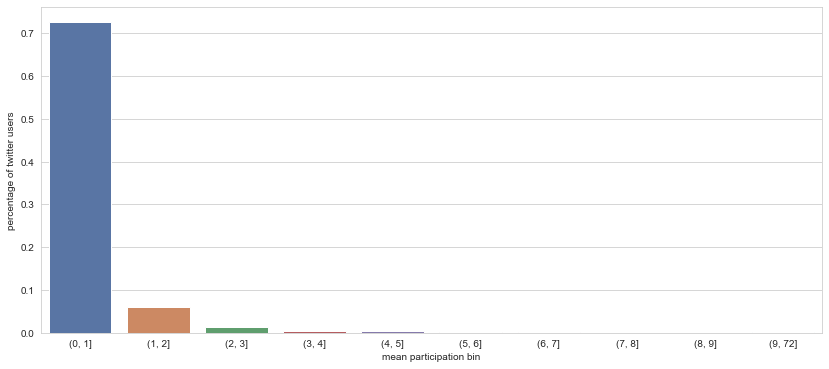

In [62]:
_, ax = plt.subplots(figsize=(14,6))
sns.set_style("whitegrid")
ax = sns.barplot(data=bin_participation, x = 'mean_par_bin', y= 'perc', palette="deep")
plt.ylabel('percentage of twitter users')
plt.xlabel('mean participation bin')

## Some Feature Extraction

In [ ]:
# example of one branch 
conv = data.loc[data.conversation_id == 'dq95b41']
conv

In [63]:
def count_op_involvment(subconv:pd.DataFrame, roots:pd.DataFrame) -> float:
    """
    counts the proportion of posts from the full conversation author in the subconversation
    """
    full_conversation_id = subconv.sample(1).full_conv_id.values[0]
    op = roots.loc[roots.full_conv_id == full_conversation_id].author.values[0]
    return len(subconv.loc[subconv.author == op]) / len(subconv)

In [ ]:
count_op_involvment(conv, roots)

In [64]:
# max branch depth 
def max_branch_depth(conv:pd.DataFrame) -> int:
    return conv.depth.max()

In [ ]:
max_branch_depth(conv)

In [65]:
# apply two features to all of the sub-conversations 
op_involvment = data.groupby('conversation_id').apply(lambda x: count_op_involvment(x, roots))

In [66]:
op_involvment.value_counts()

1.000000    510
0.500000    327
0.333333    319
0.250000    279
0.200000    270
           ... 
0.032609      1
0.158537      1
0.157895      1
0.121212      1
0.007194      1
Length: 182, dtype: int64

In [67]:
op_involvment_ = pd.DataFrame(op_involvment).rename({0:'op_involvment'}, axis=1)
op_involvment_

,op_involvment
conversation_id,
498235547685756928,0.250000
498248415223246848,0.043478
498248648699150336,0.015152
498250100079341568,0.250000
498251940997136384,0.125000
...,...
581387966125248512,0.200000
581394092648710144,0.090909
581411131547320321,0.100000


In [150]:
feature_set = data.merge(op_involvment_, how='left', on = 'conversation_id')

## Running MAXCUT

In [145]:
rumers_author_stance = []
for conversation in conversations:
    reply_interactions_parser = get_reply_interactions_parser()
    interaction_graph = reply_interactions_parser.parse(conversation)
    interaction_graph.get_core_interactions(inplace=True)
    interaction_graph.set_interaction_weights(lambda x: x['replies'])
    maxcut = MaxcutStanceClassifier()
    maxcut.set_input(interaction_graph.graph)
    op = conversation.root.author
    maxcut.classify_stance(op)
    for supporter in maxcut.supporters:
        row = {'conversation_id': conversation.id,
               'op': conversation.op,
               'author': supporter,
               'stance': 'supporter'}
        rumers_author_stance.append(row)
    for opposer in maxcut.complement:
        row = {'conversation_id': conversation.id,
               'op': conversation.op,
               'author': supporter,
               'stance': 'opposer'}
        rumers_author_stance.append(row)

In [146]:
len(rumers_author_stance)

1685

In [148]:
user_stance_rumors = pd.DataFrame(rumers_author_stance)
user_stance_rumors

,conversation_id,op,author,stance
0,553589970775343104,4970411,4970411,supporter
1,553589970775343104,4970411,21687995,supporter
2,553589970775343104,4970411,21687995,opposer
3,544512691948498944,428333,217628587,supporter
4,544512691948498944,428333,428333,supporter
...,...,...,...,...
1680,500382270340214784,1507338108,2336673134,supporter
1681,500382270340214784,1507338108,2336673134,opposer
1682,500378522398244865,230527949,60490731,supporter
1683,500378522398244865,230527949,60490731,opposer


In [270]:
user_stance_rumors.dtypes

threadid             object
op                   object
author               object
stance_prediction    object
dtype: object

In [149]:
user_stance_rumors.conversation_id.nunique()

419

## Gold Standard

In [164]:
path = r"C:\Users\ronp\Documents\stance-classification\rumors_dataset\pheme-rumour-scheme-dataset\annotations\en-scheme-annotations.json"
# path = "/Users/shaimeital/code/thesis/cmv-stance-classification/Examples/en-scheme-annotations_clean.jsonl"
rumors_gold_label = pd.read_json(path, lines = True)
rumors_gold_label


,event,threadid,tweetid,responsetype-vs-source,certainty,evidentiality,responsetype-vs-previous
0,putinmissing,577258317942149120,577260238316830720,comment,NaN,NaN,NaN
1,putinmissing,577258317942149120,577282462788677632,comment,NaN,NaN,NaN
2,putinmissing,577258317942149120,577283431089901568,comment,NaN,NaN,NaN
3,putinmissing,577258317942149120,577284294051123200,comment,NaN,NaN,NaN
4,putinmissing,577258317942149120,577287160329465856,comment,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4258,ebola-essien,521346721226711040,521371539082858496,comment,NaN,NaN,comment
4259,ebola-essien,521346721226711040,521371742942797824,comment,NaN,NaN,comment
4260,ebola-essien,521346721226711040,521353434881327104,comment,NaN,NaN,comment
4261,ebola-essien,521346721226711040,521366121484918784,disagreed,uncertain,no-evidence,comment


In [165]:
rumors_gold_label['responsetype-vs-source'].value_counts()

comment                        2923
agreed                          645
appeal-for-more-information     361
disagreed                       334
Name: responsetype-vs-source, dtype: int64

In [189]:
rumors_gold_label = rumors_gold_label.filter(['threadid', 'tweetid', 'responsetype-vs-source'], axis=1).rename({'responsetype-vs-source': 'label'}, axis=1)
rumors_gold_label

,threadid,tweetid,label
0,577258317942149120,577260238316830720,comment
1,577258317942149120,577282462788677632,comment
2,577258317942149120,577283431089901568,comment
3,577258317942149120,577284294051123200,comment
4,577258317942149120,577287160329465856,comment
...,...,...,...
4258,521346721226711040,521371539082858496,comment
4259,521346721226711040,521371742942797824,comment
4260,521346721226711040,521353434881327104,comment
4261,521346721226711040,521366121484918784,disagreed


In [231]:
rumors_gold_label.threadid = rumors_gold_label.threadid.astype('str') 

In [232]:
rumors_gold_label.tweetid = rumors_gold_label.tweetid.astype('str') 

In [234]:
rumors_gold_label.dtypes

threadid    object
tweetid     object
label       object
dtype: object

In [241]:
convs_a = convs_.filter(['threadid', 'tweetid', 'author'], axis=1)
convs_a

,threadid,tweetid,author
0,500363141034020865,500363141034020865,27172787
1,500363141034020865,500402163966025729,16515767
2,500363141034020865,500401882276585472,1639960820
3,500363141034020865,500398670358257664,1656331460
4,500363141034020865,500425964778557440,2298877380
...,...,...,...
47980,580370249712697344,580373168168140800,2779940700
47981,580370249712697344,580370623425331200,1347766734
47982,580370249712697344,580370649883021312,2611014717
47983,580370249712697344,580373657849069568,1035136412


In [271]:
convs_a.dtypes

threadid    object
tweetid     object
author      object
dtype: object

In [245]:
rumors_gold_label_ = rumors_gold_label.merge(convs_a, how = 'left', on=['threadid', 'tweetid'])
rumors_gold_label_

,threadid,tweetid,label,author
0,577258317942149120,577260238316830720,comment,NaN
1,577258317942149120,577282462788677632,comment,NaN
2,577258317942149120,577283431089901568,comment,NaN
3,577258317942149120,577284294051123200,comment,NaN
4,577258317942149120,577287160329465856,comment,NaN
...,...,...,...,...
4258,521346721226711040,521371539082858496,comment,NaN
4259,521346721226711040,521371742942797824,comment,NaN
4260,521346721226711040,521353434881327104,comment,NaN
4261,521346721226711040,521366121484918784,disagreed,NaN


In [248]:
rumors_gold_label_.author.isna().sum()

3563

In [251]:
rumors_gold_label_nona = rumors_gold_label_.dropna()
rumors_gold_label_nona

,threadid,tweetid,label,author
8,576319832800555008,576321273594294272,comment,1946971338
10,576319832800555008,576321856166346752,disagreed,2406844921
12,576319832800555008,576327925869506560,appeal-for-more-information,138681055
15,576319832800555008,576336711376056320,comment,2268785065
16,576319832800555008,576339955598942208,comment,567575673
...,...,...,...,...
4077,544277117039837184,544311853409529856,comment,1343325901
4117,525060425184858112,525083549284966400,comment,2844824016
4118,525060425184858112,525062454372757504,comment,17909802
4122,525068915068923904,525882599294517248,comment,17820367


In [260]:
user_stance_rumors = user_stance_rumors.rename({'conversation_id': 'threadid', 'stance':'stance_prediction'}, axis=1)
user_stance_rumors

,threadid,op,author,stance_prediction
0,553589970775343104,4970411,4970411,supporter
1,553589970775343104,4970411,21687995,supporter
2,553589970775343104,4970411,21687995,opposer
3,544512691948498944,428333,217628587,supporter
4,544512691948498944,428333,428333,supporter
...,...,...,...,...
1680,500382270340214784,1507338108,2336673134,supporter
1681,500382270340214784,1507338108,2336673134,opposer
1682,500378522398244865,230527949,60490731,supporter
1683,500378522398244865,230527949,60490731,opposer


In [262]:
predictions = user_stance_rumors.merge(rumors_gold_label_nona, how='left', on = ['threadid', 'author'])
predictions

,threadid,op,author,stance_prediction,tweetid,label
0,553589970775343104,4970411,4970411,supporter,NaN,NaN
1,553589970775343104,4970411,21687995,supporter,NaN,NaN
2,553589970775343104,4970411,21687995,opposer,NaN,NaN
3,544512691948498944,428333,217628587,supporter,NaN,NaN
4,544512691948498944,428333,428333,supporter,NaN,NaN
...,...,...,...,...,...,...
1701,500382270340214784,1507338108,2336673134,supporter,NaN,NaN
1702,500382270340214784,1507338108,2336673134,opposer,NaN,NaN
1703,500378522398244865,230527949,60490731,supporter,NaN,NaN
1704,500378522398244865,230527949,60490731,opposer,NaN,NaN


In [265]:
predictions_ = predictions.dropna()
predictions_

,threadid,op,author,stance_prediction,tweetid,label
19,544306719686656000,14460241,14460241,supporter,544309550778957824,comment
20,544306719686656000,14460241,316364374,supporter,544309297480364032,agreed
21,544306719686656000,14460241,316364374,supporter,544309593916989440,comment
22,544306719686656000,14460241,316364374,opposer,544309297480364032,agreed
23,544306719686656000,14460241,316364374,opposer,544309593916989440,comment
129,553549686129561600,64643056,[Unavailable],supporter,553552662088937472,comment
130,553549686129561600,64643056,[Unavailable],opposer,553552662088937472,comment
131,553549686129561600,64643056,[Unavailable],opposer,553552662088937472,comment
246,500394061887709184,14155907,122328941,supporter,500402881737289728,comment
247,500394061887709184,14155907,122328941,supporter,500410466213318656,comment


In [266]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'agreed') ]

,threadid,op,author,stance_prediction,tweetid,label
20,544306719686656000,14460241,316364374,supporter,544309297480364032,agreed
783,500389488217309184,15996661,34297193,supporter,500698984877666304,agreed


In [267]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'disagreed') ]

,threadid,op,author,stance_prediction,tweetid,label


In [268]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'disagreed') ]

,threadid,op,author,stance_prediction,tweetid,label
383,500298752469770240,231094495,2373121802,supporter,500322663823589376,disagreed
388,500298752469770240,231094495,2373121802,supporter,500324396285054976,disagreed
389,500298752469770240,231094495,2373121802,supporter,500324845427916800,disagreed


In [269]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'agreed') ]

,threadid,op,author,stance_prediction,tweetid,label
22,544306719686656000,14460241,316364374,opposer,544309297480364032,agreed


## Extra for TSNE + PCA

In [ ]:
# data = pd.DataFrame.from_records(features, index="conv_id")
# print(data.head())

In [ ]:
data_ = data.loc[data.num_nodes > 10]

In [ ]:
data_.count()

In [ ]:
data_

In [ ]:
data_.describe()

In [ ]:
data_ = data_.fillna(0)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [ ]:
standardized_data = StandardScaler().fit_transform(data_)
print(standardized_data.shape)

In [ ]:
model = TSNE(n_components=2, random_state=0)

In [ ]:
tsne_data = model.fit_transform(standardized_data)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.FacetGrid(tsne_df, height=9).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN


In [ ]:
m = DBSCAN()


In [ ]:
m.fit(standardized_data)

In [ ]:
clusters = m.labels_

In [ ]:
pd.Series(clusters).value_counts()

In [ ]:
# pca

from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)


In [ ]:
principalComponents = pca.fit_transform(standardized_data)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
sns.FacetGrid(principalDf, height=6).map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
plt.show()